In [3]:
import numpy as np
import matplotlib.pyplot as plt

class SelfAttention:
    def __init__(self, d_model, num_heads):
        """
        Initialize a self-attention layer.
        
        Args:
            d_model (int): Dimension of the model (embedding dimension)
            num_heads (int): Number of attention heads
        """
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Initialize weights for Query, Key, and Value projections
        self.W_q = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_k = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_v = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_o = np.random.randn(d_model, d_model) / np.sqrt(d_model)
    
    def split_heads(self, x):
        """Split the last dimension into (num_heads, d_k)"""
        batch_size, seq_length = x.shape[0], x.shape[1]
        return x.reshape(batch_size, seq_length, self.num_heads, self.d_k).transpose(0, 2, 1, 3)
    
    def combine_heads(self, x):
        """Combine the heads back"""
        batch_size, seq_length = x.shape[0], x.shape[2]
        return x.transpose(0, 2, 1, 3).reshape(batch_size, seq_length, self.d_model)
    
    def forward(self, x):
        """
        Compute self-attention.
        
        Args:
            x (numpy.ndarray): Input tensor of shape (batch_size, seq_length, d_model)
            
        Returns:
            tuple: (output, attention_scores)
        """
        batch_size, seq_length = x.shape[0], x.shape[1]
        
        # Linear projections
        q = np.matmul(x, self.W_q)  # (batch_size, seq_length, d_model)
        k = np.matmul(x, self.W_k)  # (batch_size, seq_length, d_model)
        v = np.matmul(x, self.W_v)  # (batch_size, seq_length, d_model)
        
        # Split heads
        q = self.split_heads(q)  # (batch_size, num_heads, seq_length, d_k)
        k = self.split_heads(k)  # (batch_size, num_heads, seq_length, d_k)
        v = self.split_heads(v)  # (batch_size, num_heads, seq_length, d_k)
        
        # Scaled dot-product attention
        scores = np.matmul(q, k.transpose(0, 1, 3, 2)) / np.sqrt(self.d_k)
        # scores has shape (batch_size, num_heads, seq_length, seq_length)
        
        # Apply softmax to get attention weights
        attention_weights = self.softmax(scores)
        
        # Apply attention weights to values
        context = np.matmul(attention_weights, v)  # (batch_size, num_heads, seq_length, d_k)
        
        # Combine heads
        context = self.combine_heads(context)  # (batch_size, seq_length, d_model)
        
        # Final linear projection
        output = np.matmul(context, self.W_o)  # (batch_size, seq_length, d_model)
        
        return output, attention_weights
    
    def softmax(self, x):
        """Compute softmax values for each set of scores in x."""
        # Apply softmax per row
        # Subtracting the max for numerical stability
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)


def visualize_attention(tokens, attention_matrix, head_idx=0):
    """
    Visualize attention weights.
    
    Args:
        tokens (list): List of tokens
        attention_matrix (numpy.ndarray): Attention matrix of shape 
                                         (batch_size, num_heads, seq_length, seq_length)
        head_idx (int): Index of the head to visualize
    """
    # Get the attention weights for the specified head
    attn = attention_matrix[0, head_idx]  # (seq_length, seq_length)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(attn, cmap='viridis')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            text = ax.text(j, i, f"{attn[i, j]:.2f}",
                           ha="center", va="center", color="w")
    
    ax.set_title(f"Attention weights (Head {head_idx})")
    fig.tight_layout()
    plt.colorbar(im)
    return fig


def tokenize_simple(sentence):
    """Simple tokenization by splitting on spaces and punctuation."""
    # Replace punctuation with spaces, then split on whitespace
    for char in ".,;:!?":
        sentence = sentence.replace(char, f" {char} ")
    return sentence.split()


def embed_tokens(tokens, embedding_dim=64):
    """
    Create simple random embeddings for tokens.
    
    Args:
        tokens (list): List of tokens
        embedding_dim (int): Dimension of embeddings
        
    Returns:
        numpy.ndarray: Embeddings of shape (1, len(tokens), embedding_dim)
    """
    # Using random embeddings for demonstration
    embeddings = np.random.randn(len(tokens), embedding_dim) / np.sqrt(embedding_dim)
    return np.expand_dims(embeddings, axis=0)  # Add batch dimension


Tokens: ['Diabetes', 'is', 'a', 'chronic', 'condition', 'characterized', 'by', 'high', 'blood', 'sugar', 'levels', '.']
Embeddings shape: (1, 12, 64)
Output shape: (1, 12, 64)
Attention weights shape: (1, 4, 12, 12)


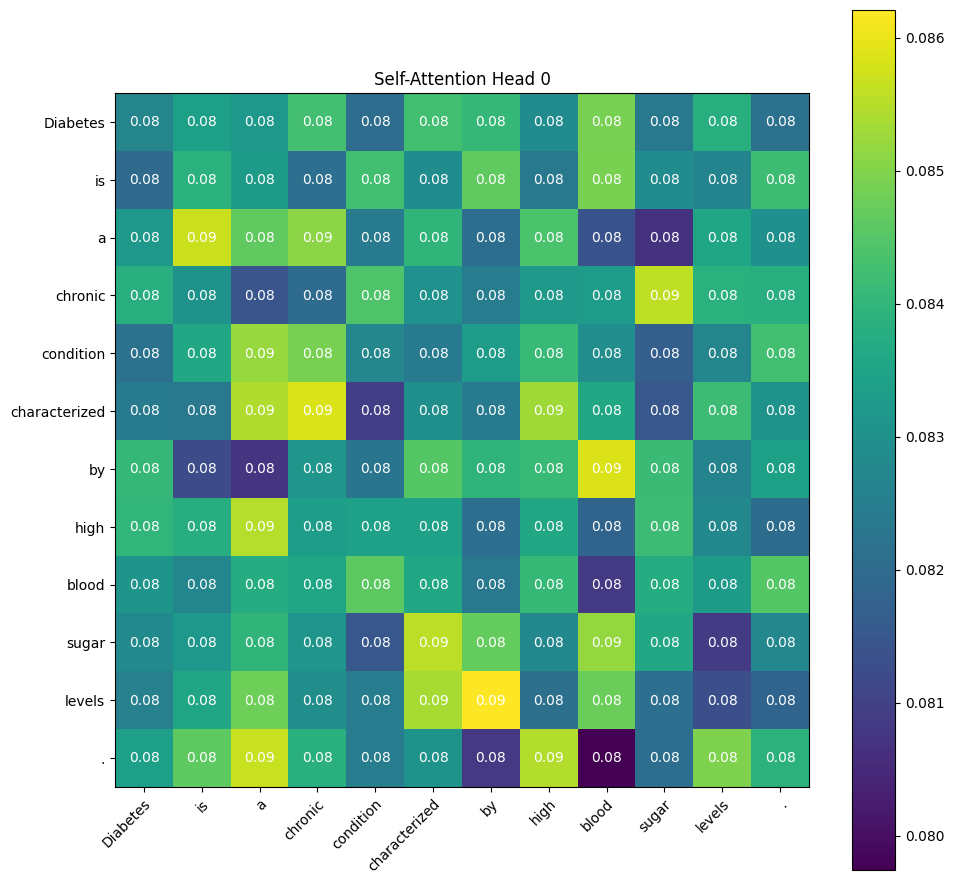

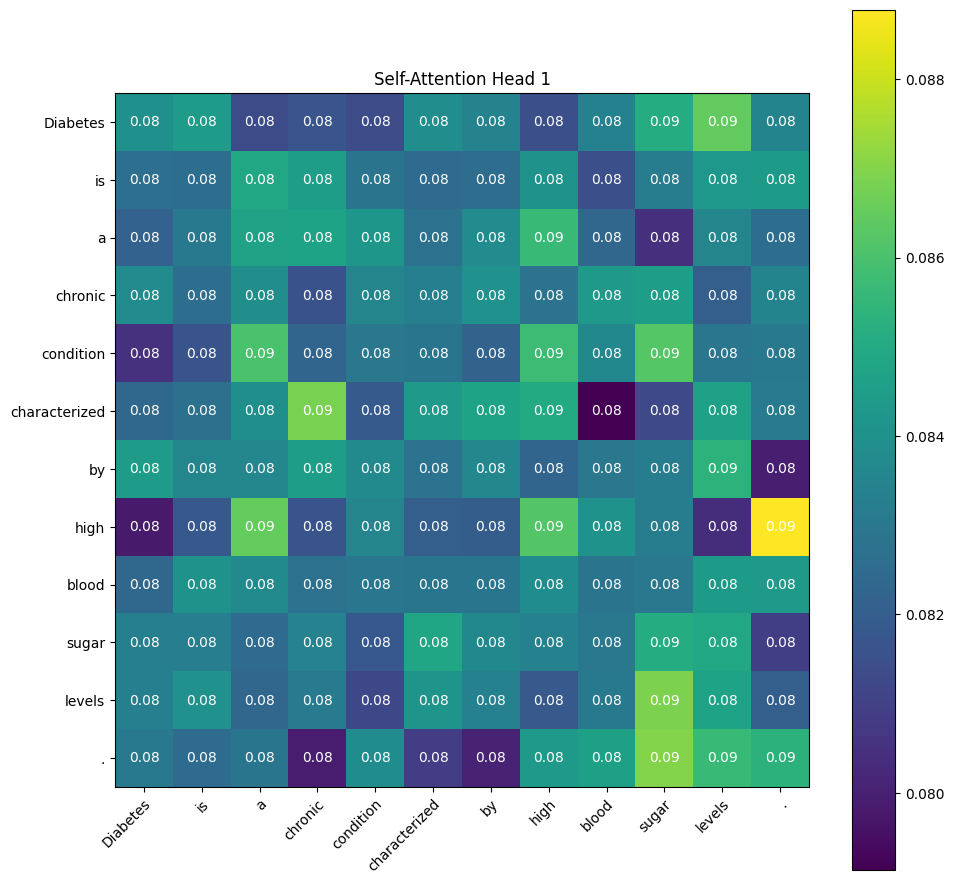

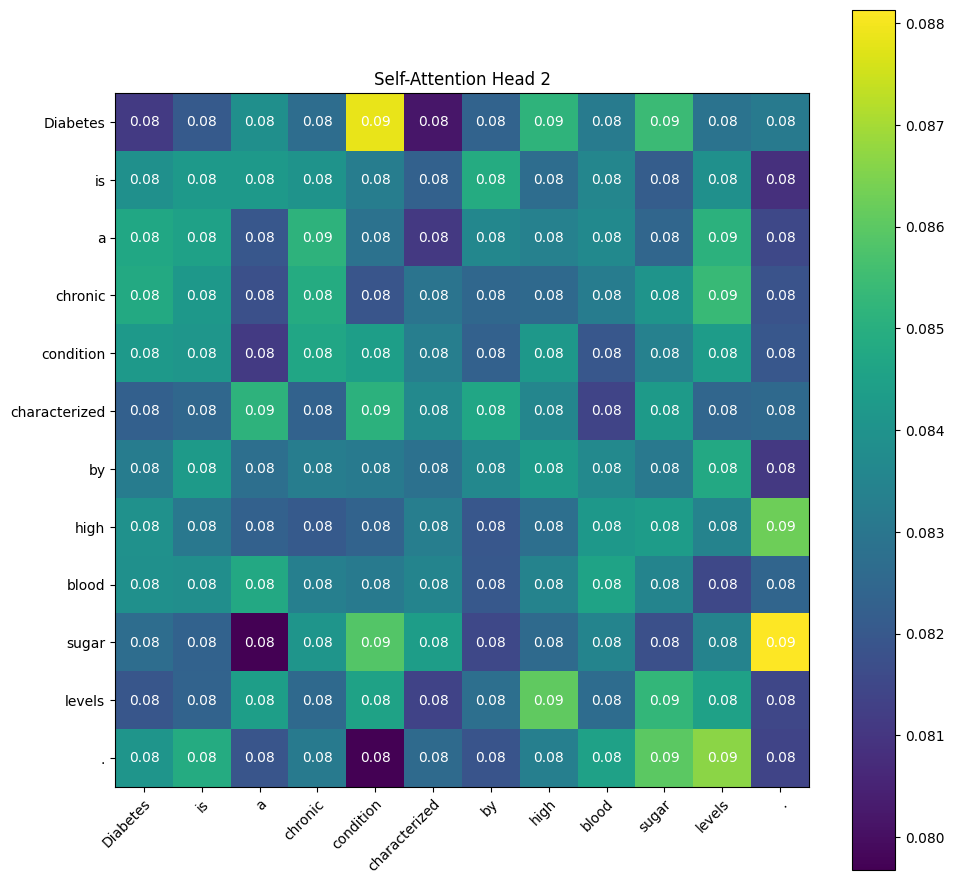

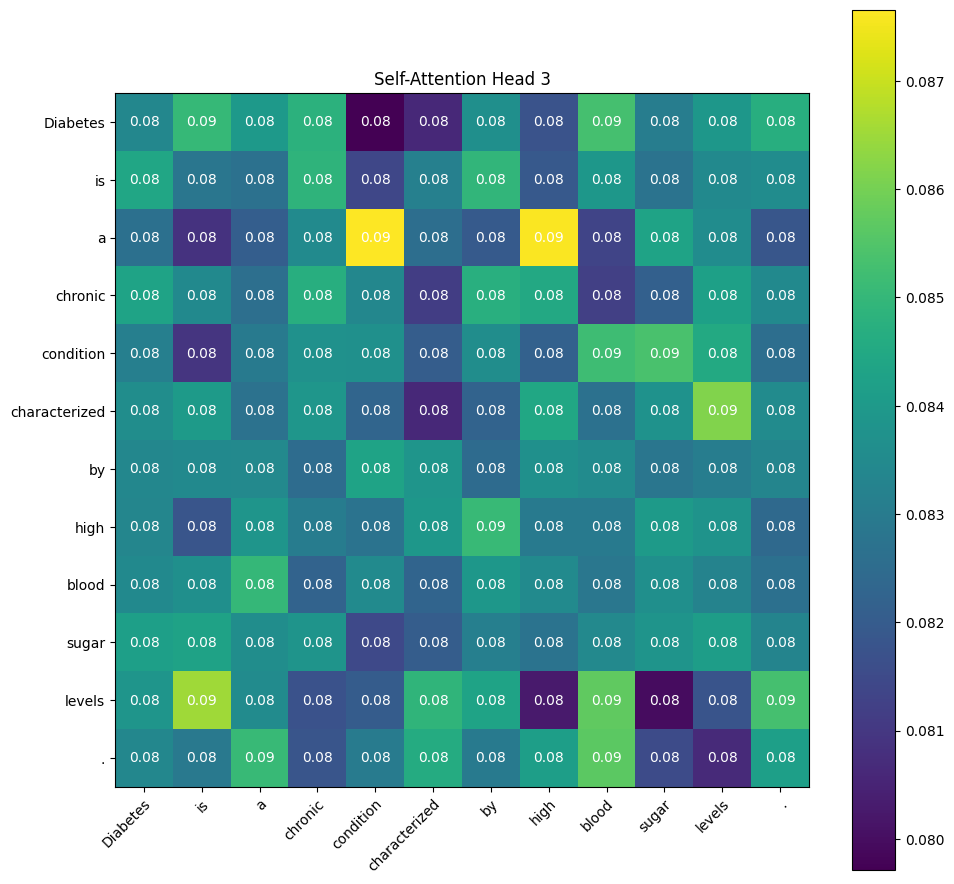

In [4]:
# Example sentence from the medical paper
sentence = "Diabetes is a chronic condition characterized by high blood sugar levels."

# Tokenize the sentence
tokens = tokenize_simple(sentence)
print(f"Tokens: {tokens}")

# Create embeddings
embedding_dim = 64
embeddings = embed_tokens(tokens, embedding_dim)
print(f"Embeddings shape: {embeddings.shape}")

# Initialize self-attention layer
num_heads = 4
self_attention = SelfAttention(embedding_dim, num_heads)

# Compute self-attention
output, attention_weights = self_attention.forward(embeddings)
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

# Visualize attention for each head
for head_idx in range(num_heads):
    fig = visualize_attention(tokens, attention_weights, head_idx)
    plt.title(f"Self-Attention Head {head_idx}")
    plt.show()


In [5]:
class EncoderDecoderAttention:
    def __init__(self, d_model, num_heads):
        """
        Initialize an encoder-decoder attention layer.
        
        Args:
            d_model (int): Dimension of the model (embedding dimension)
            num_heads (int): Number of attention heads
        """
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Initialize weights for Query, Key, and Value projections
        # Query comes from decoder, Keys and Values from encoder
        self.W_q = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_k = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_v = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_o = np.random.randn(d_model, d_model) / np.sqrt(d_model)
    
    def split_heads(self, x):
        """Split the last dimension into (num_heads, d_k)"""
        batch_size, seq_length = x.shape[0], x.shape[1]
        return x.reshape(batch_size, seq_length, self.num_heads, self.d_k).transpose(0, 2, 1, 3)
    
    def combine_heads(self, x):
        """Combine the heads back"""
        batch_size, seq_length = x.shape[0], x.shape[2]
        return x.transpose(0, 2, 1, 3).reshape(batch_size, seq_length, self.d_model)
    
    def forward(self, decoder_input, encoder_output):
        """
        Compute encoder-decoder attention.
        
        Args:
            decoder_input (numpy.ndarray): Decoder input of shape (batch_size, target_len, d_model)
            encoder_output (numpy.ndarray): Encoder output of shape (batch_size, source_len, d_model)
            
        Returns:
            tuple: (output, attention_scores)
        """
        batch_size = decoder_input.shape[0]
        target_len = decoder_input.shape[1]
        source_len = encoder_output.shape[1]
        
        # Linear projections
        # Query comes from the decoder
        q = np.matmul(decoder_input, self.W_q)  # (batch_size, target_len, d_model)
        # Keys and Values come from the encoder
        k = np.matmul(encoder_output, self.W_k)  # (batch_size, source_len, d_model)
        v = np.matmul(encoder_output, self.W_v)  # (batch_size, source_len, d_model)
        
        # Split heads
        q = self.split_heads(q)  # (batch_size, num_heads, target_len, d_k)
        k = self.split_heads(k)  # (batch_size, num_heads, source_len, d_k)
        v = self.split_heads(v)  # (batch_size, num_heads, source_len, d_k)
        
        # Scaled dot-product attention
        scores = np.matmul(q, k.transpose(0, 1, 3, 2)) / np.sqrt(self.d_k)
        # scores has shape (batch_size, num_heads, target_len, source_len)
        
        # Apply softmax to get attention weights
        attention_weights = self.softmax(scores)
        
        # Apply attention weights to values
        context = np.matmul(attention_weights, v)  # (batch_size, num_heads, target_len, d_k)
        
        # Combine heads
        context = self.combine_heads(context)  # (batch_size, target_len, d_model)
        
        # Final linear projection
        output = np.matmul(context, self.W_o)  # (batch_size, target_len, d_model)
        
        return output, attention_weights
    
    def softmax(self, x):
        """Compute softmax values for each set of scores in x."""
        # Apply softmax per row
        # Subtracting the max for numerical stability
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)


def visualize_enc_dec_attention(source_tokens, target_tokens, attention_matrix, head_idx=0):
    """
    Visualize encoder-decoder attention weights.
    
    Args:
        source_tokens (list): List of source tokens (from encoder)
        target_tokens (list): List of target tokens (from decoder)
        attention_matrix (numpy.ndarray): Attention matrix of shape 
                                         (batch_size, num_heads, target_len, source_len)
        head_idx (int): Index of the head to visualize
    """
    # Get the attention weights for the specified head
    attn = attention_matrix[0, head_idx]  # (target_len, source_len)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(attn, cmap='viridis')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(source_tokens)))
    ax.set_yticks(np.arange(len(target_tokens)))
    ax.set_xticklabels(source_tokens)
    ax.set_yticklabels(target_tokens)
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    for i in range(len(target_tokens)):
        for j in range(len(source_tokens)):
            text = ax.text(j, i, f"{attn[i, j]:.2f}",
                          ha="center", va="center", color="w")
    
    ax.set_title(f"Encoder-Decoder Attention weights (Head {head_idx})")
    ax.set_xlabel("Source tokens (Encoder)")
    ax.set_ylabel("Target tokens (Decoder)")
    fig.tight_layout()
    plt.colorbar(im)
    return fig

Passage tokens: ['Diabetes', 'is', 'a', 'chronic', 'condition', 'characterized', 'by', 'high', 'blood', 'sugar', 'levels', '.', 'Common', 'symptoms', 'include', 'increased', 'thirst', ',', 'frequent', 'urination', ',', 'extreme', 'fatigue', ',', 'and', 'blurred', 'vision', '.']
Question tokens: ['What', 'are', 'the', 'symptoms', 'of', 'diabetes', '?']
Partial answer tokens: ['The', 'symptoms', 'are']

Step 1: Encode the passage using self-attention
Encoder output shape: (1, 28, 64)
Encoder self-attention shape: (1, 4, 28, 28)

Step 2: Encode the question using self-attention
Question encoder output shape: (1, 7, 64)

Step 3: Initial decoding of partial answer using self-attention
Decoder output shape: (1, 3, 64)

Step 4: Encoder-Decoder Attention
Output shape: (1, 3, 64)
Attention weights shape: (1, 4, 3, 28)


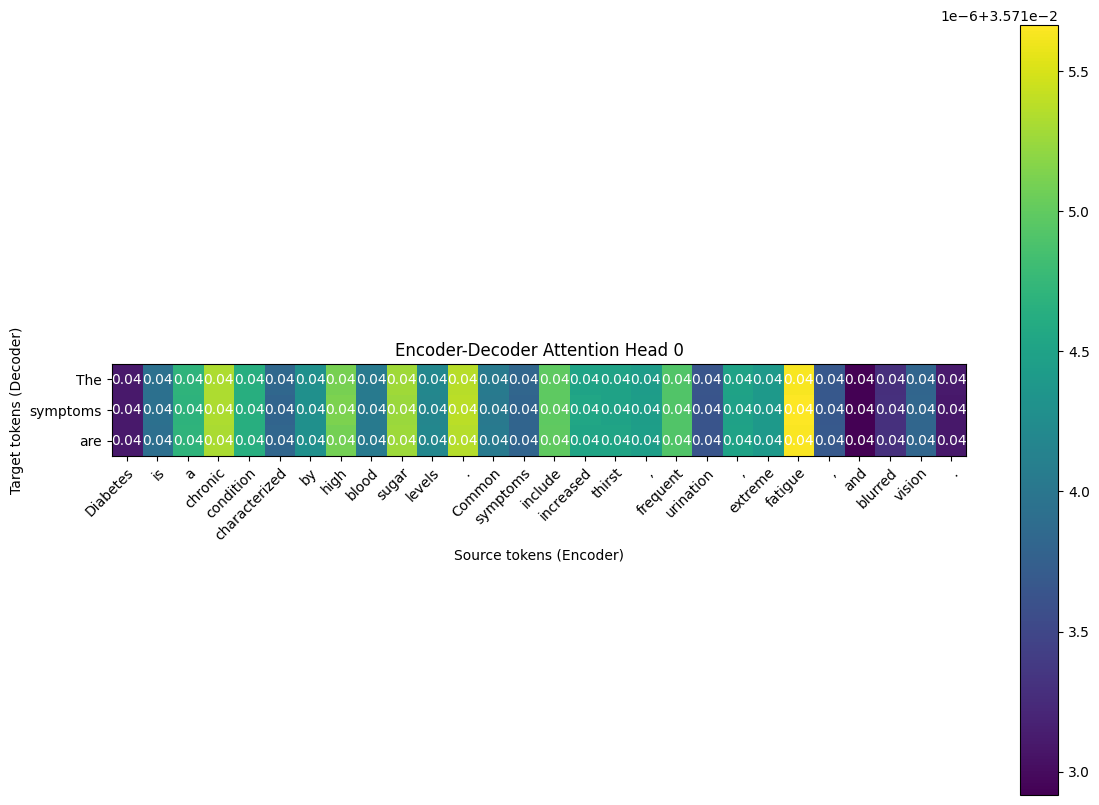

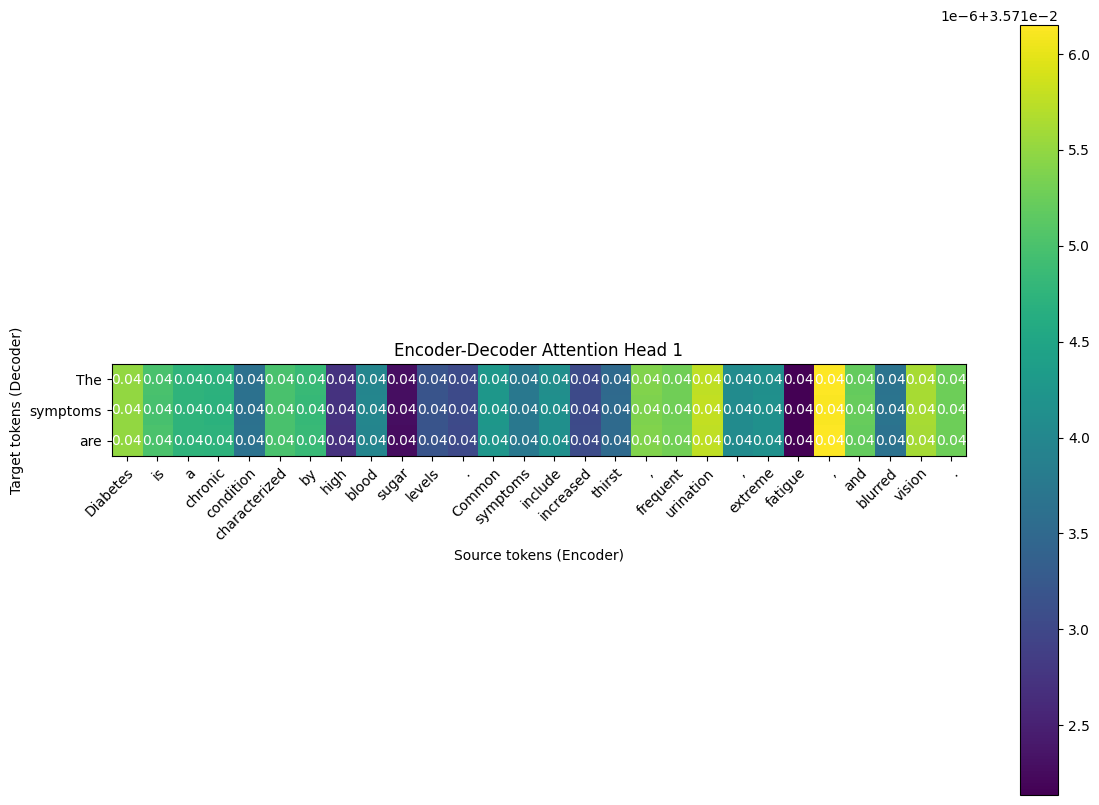

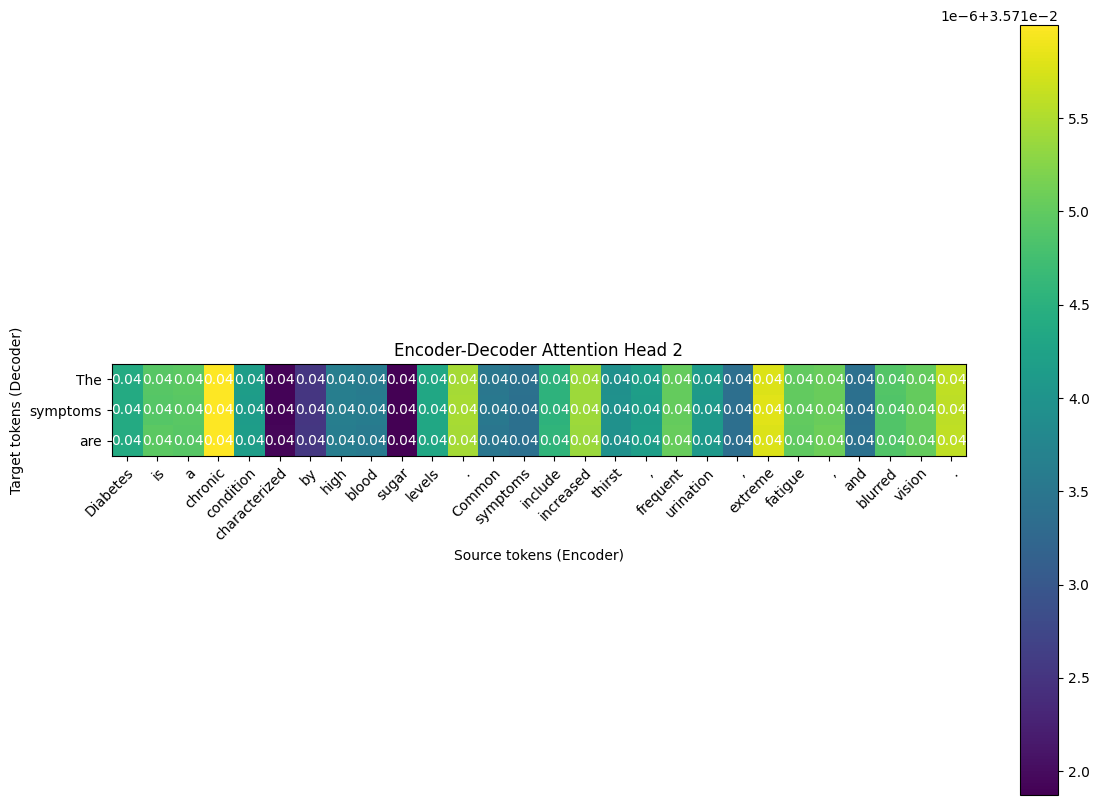

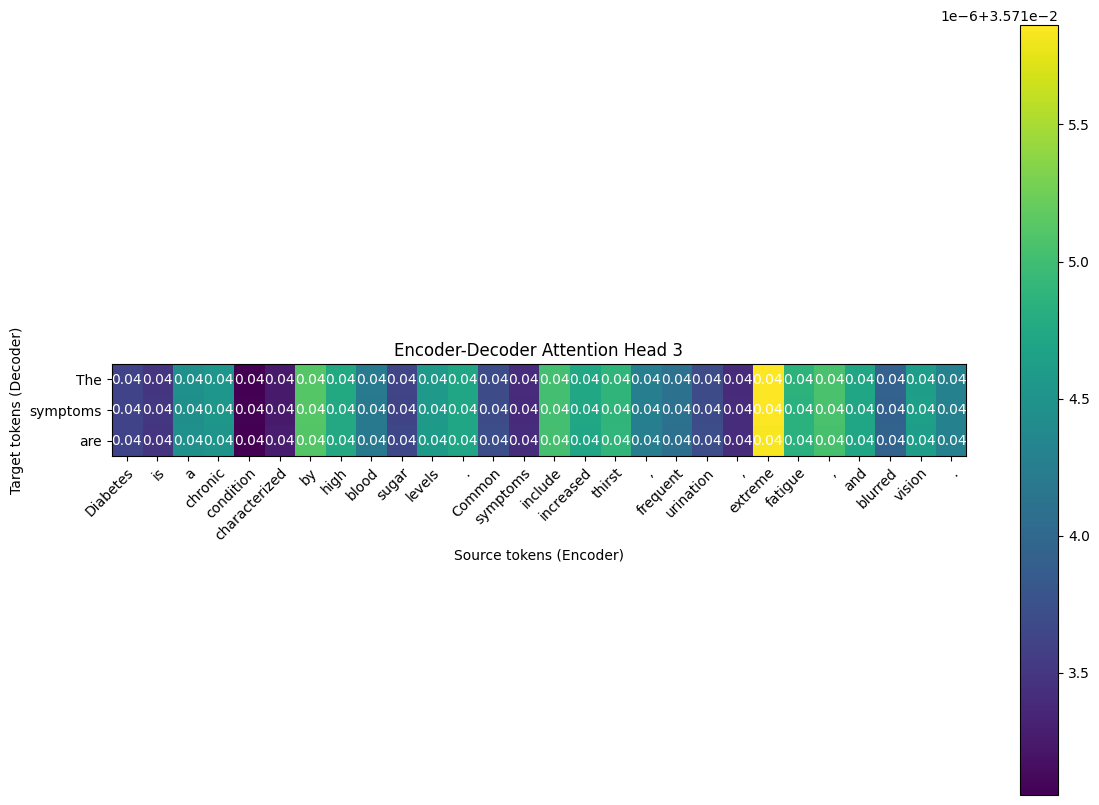

In [6]:
# Example passage from a medical paper
passage = "Diabetes is a chronic condition characterized by high blood sugar levels. Common symptoms include increased thirst, frequent urination, extreme fatigue, and blurred vision."

# Example question
question = "What are the symptoms of diabetes?"

# Tokenize the passage and question
passage_tokens = tokenize_simple(passage)
question_tokens = tokenize_simple(question)

# For the decoder output simulation, use partial answer
partial_answer = "The symptoms are"
partial_answer_tokens = tokenize_simple(partial_answer)

print(f"Passage tokens: {passage_tokens}")
print(f"Question tokens: {question_tokens}")
print(f"Partial answer tokens: {partial_answer_tokens}")

# %%
# Create embeddings
embedding_dim = 64
passage_embeddings = embed_tokens(passage_tokens, embedding_dim)
question_embeddings = embed_tokens(question_tokens, embedding_dim)
partial_answer_embeddings = embed_tokens(partial_answer_tokens, embedding_dim)

# Step 1: Encoder self-attention for the passage
encoder_self_attention = SelfAttention(embedding_dim, num_heads=4)
encoder_output, encoder_attention = encoder_self_attention.forward(passage_embeddings)

print("\nStep 1: Encode the passage using self-attention")
print(f"Encoder output shape: {encoder_output.shape}")
print(f"Encoder self-attention shape: {encoder_attention.shape}")

# Step 2: Encode the question
question_encoder = SelfAttention(embedding_dim, num_heads=4)
question_output, _ = question_encoder.forward(question_embeddings)

print("\nStep 2: Encode the question using self-attention")
print(f"Question encoder output shape: {question_output.shape}")

# Step 3: Decoder self-attention for the partial answer
decoder_self_attention = SelfAttention(embedding_dim, num_heads=4)
decoder_output, decoder_attention = decoder_self_attention.forward(partial_answer_embeddings)

print("\nStep 3: Initial decoding of partial answer using self-attention")
print(f"Decoder output shape: {decoder_output.shape}")

# %%
# Step 4: Encoder-Decoder attention between partial answer and passage
enc_dec_attention = EncoderDecoderAttention(embedding_dim, num_heads=4)
output, attention_weights = enc_dec_attention.forward(decoder_output, encoder_output)

print("\nStep 4: Encoder-Decoder Attention")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

# Visualize encoder-decoder attention for each head
for head_idx in range(4):
    fig = visualize_enc_dec_attention(passage_tokens, partial_answer_tokens, attention_weights, head_idx)
    plt.title(f"Encoder-Decoder Attention Head {head_idx}")
    plt.show()


In [7]:
def create_simple_vocab(passage, question, additional_words=None):
    """
    Create a simple vocabulary from passage and question tokens.
    
    Args:
        passage (str): The passage text
        question (str): The question text
        additional_words (list): Additional words to include in vocabulary
        
    Returns:
        tuple: (word2idx, idx2word) dictionaries for vocabulary mapping
    """
    # Tokenize passage and question
    passage_tokens = tokenize_simple(passage)
    question_tokens = tokenize_simple(question)
    
    # Create vocabulary
    vocab = set(passage_tokens + question_tokens)
    if additional_words:
        vocab.update(additional_words)
    
    # Create mappings
    word2idx = {word: idx for idx, word in enumerate(sorted(vocab))}
    idx2word = {idx: word for word, idx in word2idx.items()}
    
    return word2idx, idx2word

# Create vocabulary from our example
additional_words = ["<START>", "<END>", "increased", "thirst", "frequent", "urination", "extreme", "fatigue", "blurred", "vision"]
word2idx, idx2word = create_simple_vocab(passage, question, additional_words)
vocab_size = len(word2idx)

print(f"Vocabulary size: {vocab_size}")
print(f"First 10 words: {[idx2word[i] for i in range(min(10, vocab_size))]}")

# %%
# Simplified projection layer to convert decoder output to vocabulary distribution
class OutputProjection:
    def __init__(self, d_model, vocab_size):
        """
        Initialize output projection layer.
        
        Args:
            d_model (int): Model dimension
            vocab_size (int): Size of vocabulary
        """
        self.W = np.random.randn(d_model, vocab_size) / np.sqrt(d_model)
        self.b = np.zeros(vocab_size)
        
    def forward(self, x):
        """
        Project decoder output to vocabulary distribution.
        
        Args:
            x (numpy.ndarray): Decoder output of shape (batch_size, seq_length, d_model)
            
        Returns:
            numpy.ndarray: Logits of shape (batch_size, seq_length, vocab_size)
        """
        # x has shape (batch_size, seq_length, d_model)
        return np.matmul(x, self.W) + self.b  # (batch_size, seq_length, vocab_size)
    
    def softmax(self, x):
        """Apply softmax along the vocabulary dimension."""
        # x has shape (batch_size, seq_length, vocab_size)
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)  # (batch_size, seq_length, vocab_size)


Vocabulary size: 33
First 10 words: [',', '.', '<END>', '<START>', '?', 'Common', 'Diabetes', 'What', 'a', 'and']


In [8]:
# Initialize output projection layer
output_projection = OutputProjection(embedding_dim, vocab_size)

# Get logits for next token prediction
logits = output_projection.forward(output)  # output from encoder-decoder attention
print(f"Logits shape: {logits.shape}")  # (batch_size, target_len, vocab_size)

# Apply softmax to get probability distribution over vocabulary
next_token_probs = output_projection.softmax(logits)
print(f"Next token probabilities shape: {next_token_probs.shape}")


Logits shape: (1, 3, 33)
Next token probabilities shape: (1, 3, 33)


In [14]:
# %%
# For demonstration, let's extract the probabilities for the last token in our partial answer
# This would be the prediction for what comes after "The symptoms are"
last_token_idx = partial_answer_tokens.index("are")
last_token_probs = next_token_probs[0, last_token_idx, :]  # Extract probabilities for the last token

# Get top 5 most likely next tokens
top_k = 5
top_indices = np.argsort(last_token_probs)[-top_k:][::-1]
top_words = [idx2word[idx] for idx in top_indices]
top_probs = last_token_probs[top_indices]

# Print the top-k predictions
print(f"Top {top_k} predictions for the token after '{partial_answer}':")
for word, prob in zip(top_words, top_probs):
    print(f"  {word}: {prob:.4f}")



Top 5 predictions for the token after 'The symptoms are':
  urination: 0.0313
  include: 0.0313
  levels: 0.0310
  thirst: 0.0310
  Common: 0.0309


In [11]:
def generate_answer(encoder_output, start_tokens, max_length=10, temperature=1.0):
    """
    Generate an answer using encoder-decoder attention.
    
    Args:
        encoder_output (numpy.ndarray): Encoded passage
        start_tokens (list): Initial tokens to start generation
        max_length (int): Maximum length of generated answer
        temperature (float): Sampling temperature (1.0 = greedy, 0.0 = argmax)
        
    Returns:
        list: Generated answer tokens
    """
    # Convert start tokens to embeddings
    current_output = embed_tokens(start_tokens, embedding_dim)
    
    # Initialize decoder and encoder-decoder attention
    decoder = SelfAttention(embedding_dim, num_heads=4)
    enc_dec_attn = EncoderDecoderAttention(embedding_dim, num_heads=4)
    projection = OutputProjection(embedding_dim, vocab_size)
    
    # Keep track of generated tokens
    generated_tokens = start_tokens.copy()
    
    # Generate tokens one by one
    for _ in range(max_length - len(start_tokens)):
        # 1. Apply decoder self-attention
        decoder_output, _ = decoder.forward(current_output)
        
        # 2. Apply encoder-decoder attention
        dec_enc_output, _ = enc_dec_attn.forward(decoder_output, encoder_output)
        
        # 3. Project to vocabulary distribution
        logits = projection.forward(dec_enc_output)
        
        # 4. Get probabilities for the last token
        next_token_probs = projection.softmax(logits)[0, -1, :]
        
        # 5. Handle temperature for sampling
        if temperature == 0.0:
            # For temperature 0, just take the argmax (deterministic)
            next_token_idx = np.argmax(next_token_probs)
        else:
            # Apply temperature scaling for sampling
            if temperature != 1.0:
                next_token_probs = np.power(next_token_probs, 1.0 / temperature)
                next_token_probs /= np.sum(next_token_probs)
            
            # Sample according to the distribution
            next_token_idx = np.random.choice(vocab_size, p=next_token_probs)
        
        next_token = idx2word[next_token_idx]
        
        # 7. Add the new token
        generated_tokens.append(next_token)
        
        # 8. If we generated an end token, stop
        if next_token == "<END>":
            break
        
        # 9. Update current output by adding the new token embedding
        next_token_embedding = embed_tokens([next_token], embedding_dim)
        current_output = np.concatenate(
            [current_output, next_token_embedding.reshape(1, 1, embedding_dim)], 
            axis=1
        )
    
    return generated_tokens

# %%
# Generate answers with different temperatures
print("Generating complete answers to 'What are the symptoms of diabetes?'")
print("\nStarting with: 'The symptoms are'")

# Using the encoder output we already computed
for temp in [0.0, 0.5, 1.0]:
    np.random.seed(42)  # For reproducibility
    generated_tokens = generate_answer(
        encoder_output=encoder_output,
        start_tokens=partial_answer_tokens,
        max_length=15,
        temperature=temp
    )
    
    print(f"\nGenerated answer (temperature={temp}):")
    print(" ".join(generated_tokens))
 

Generating complete answers to 'What are the symptoms of diabetes?'

Starting with: 'The symptoms are'

Generated answer (temperature=0.0):
The symptoms are What What What What What What What What What What What What

Generated answer (temperature=0.5):
The symptoms are chronic Common fatigue a blurred condition characterized of symptoms <END>

Generated answer (temperature=1.0):
The symptoms are chronic Common fatigue a blurred condition characterized of symptoms <END>
